# DQN (Deep Q-Learning)

## Step 1: Import the libraries

In [1]:
import tensorflow as tf      # Deep Learning library
import numpy as np           # Handle matrices
import pandas as pd

import random                # Handling random number generati on
import time                  # Handling time calculation
from skimage import transform# Help us to preprocess the frames

from collections import deque# Ordered collection with ends
import matplotlib.pyplot as plt # Display graphs

import warnings # This ignore all the warning messages that are normally printed during the training because of skiimage
warnings.filterwarnings('ignore') 

## Step 2: Create our environment 🎮
- Now that we imported the libraries/dependencies, we will create our environment.


In [2]:
### Parameters for the Environment

# Capacity of the energy storage
BATTERY_CAPACITY = 900   

# Rate of discharge/charging of the energy storage
BATTERY_DISCHARGE = 300  

# Maximum demand that the consumer can make, above which penality will be imposed
MAXIMUM_DEMAND_LIMIT = 1000

# Penality for exceeding the maximum demand limit 
PENALITY_EXCEED_DEMAND =  0  

DATASET_DIR = 'dataset/aravali.csv'

In [3]:

class env(object):
    
    def __init__ (self):
    
        self.read_dataset()
        self.iter = 0
        self.max_battery = BATTERY_CAPACITY
        self.battery = BATTERY_CAPACITY
        self.charge_battery = BATTERY_DISCHARGE
        self.reward = 0
        self.exceed_demand = 0
        
        self.obs=[]
        self.set_observation()
        self.done = False
        self.info = ""
        self.action_space = [[0,0,1],[0,1,0],[1,0,0]] #['grid', 'battery', 'charge']
        self.obs_space = len(self.obs)
       

    #setting the first observation
    def set_observation(self):
        dict={}
        price=[]
        for x in range(24):
            if(x<9):
                price.append(1)
            elif(x<17):
                price.append(3)
            else:
                price.append(2)
                
        dict['price'] = price
        dict['battery'] = self.battery
        dict['load'] = self.dataset['load'][self.iter]
        self.observation =  dict
        self.obs = [p for p in price]
        self.obs.append(self.observation['battery'])
        self.obs.append(self.observation['load'])
    
    
    def read_dataset(self):
        try:
            df=pd.read_csv(DATASET_DIR)
        except e:
            print("Error loading the file, check if file exists !")
        df['load']= df['W1'] + df['W2'] + df['W3']
        for name in list(df):
            if(name not in ['TS','load']):
                self.dataset=df.drop(name,axis=1)
        self.dataset.fillna(0)  
    
    
    
    def step(self, action):
        
        #Making sure the action taken is valid
        if action not in self.action_space:
            raise ValueError('Invalid Action Space')
        
        #calc reward for the action based on the action choosen
        curr_demand = self.dataset['load'][self.iter]
        grid_price = self.observation['price'][0]
        
        #Satisfy the complete consumer demand from the grid
        if(action==self.action_space[0]): 
            self.reward = curr_demand * grid_price
            if(curr_demand > MAXIMUM_DEMAND_LIMIT):
                self.exceed_demand += 1
        
        
        #Satisfy Demand from the battery and the
        if(action==self.action_space[1]): 
            if(self.battery<=0):
                self.reward = curr_demand * grid_price
                if(curr_demand > MAXIMUM_DEMAND_LIMIT):
                    self.exceed_demand += 1
            else:  #after the battery is completly drained
                battery_satisfy = min(curr_demand, self.charge_battery, self.battery)
                self.battery = self.battery - battery_satisfy
                self.reward =  (curr_demand - battery_satisfy) * grid_price  
                if((curr_demand - battery_satisfy) > MAXIMUM_DEMAND_LIMIT):
                    self.exceed_demand += 1
        
        #Charging cycle for the storage device, demand is satisfied by the grid
        if(action==self.action_space[2]):  #'charge'
            battery_charge = min(self.charge_battery, self.max_battery-self.battery)
            self.battery = self.battery + battery_charge
            self.reward = (curr_demand+battery_charge) * grid_price
            if((curr_demand + battery_charge) > MAXIMUM_DEMAND_LIMIT):
                    self.exceed_demand += 1
        
        
        #Penaility for crossing the maximum demand limit
        if(curr_demand >= MAXIMUM_DEMAND_LIMIT):
            self.reward += (curr_demand - MAXIMUM_DEMAND_LIMIT) * PENALITY_EXCEED_DEMAND
        
        
        #Reward to be returned
        self.reward = -1 * self.reward
        
        #Updating the price
        price = self.observation['price'][1:]
        price.append(self.observation['price'][0])
        self.observation['price'] = price
        self.observation['battery'] = self.battery
        
        #Next Demand
        self.iter = self.iter+1
        self.observation['load'] = self.dataset['load'][self.iter]
        
        #Creating the next observation
        self.obs = [p for p in price]
        self.obs.append(self.observation['battery'])
        self.obs.append(self.observation['load'])
        return self.obs, self.reward, self.done, self.info
    
    
    #resets all the variables and 
    def reset(self):
        self.iter = 0
        self.reward = 0
        self.done = False
        self.info = ""
        self.set_observation()
        self.exceed_demand = 0
        return self.obs
    

    
    def render(self):
        df = self.dataset
        avg=[0.0 for x in range(24)]
        days= int(df.shape[0]/24)   
        print("Number of days in dataset" +str(days))  #The dataset is not good
        days=10
        for i in range(days): #compute the aver
            avg = [ float(a) + float(b) for a,b in zip(avg, df['load'][(i*24):(i*24)+24]) ]
        
        time_shift = self.iter %24
        print("Time shift " +str(time_shift))
        avg = [x/days for x in avg]
        print("Average consumption per day " +str(sum(avg)))
        curr_profile = list(df['load'][(self.iter):self.iter+24])      

        x=[a for a in range(24)]
        y=[avg, curr_profile]
        labels = ['Average','Random Day']
        for y_arr, label in zip(y, labels):
            plt.plot(x, y_arr, label=label)
        
        plt.xlabel('time (hours)')
        plt.ylabel('Consumption (Wh)')   
        plt.legend()
        plt.show()

Number of days in dataset253
Time shift 0
Average consumption per day 5939.569130586826


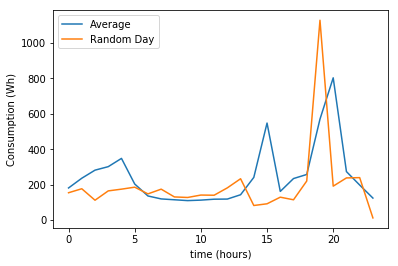

In [4]:
game = env()
game.render()

## Step 4: Set up our hyperparameters 

In [5]:
learning_rate =  0.001      # Alpha (aka learning rate)
state_size = [game.obs_space]
action_size = len(game.action_space)
possible_actions = game.action_space

### TRAINING HYPERPARAMETERS
total_episodes = 1000        # Total episodes for training
max_steps = 24*30              # Max possible steps in an episode
batch_size = 64             

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.995            # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.95               # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 10000          # Number of experiences the Memory can keep

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

## Step 5: Create our Deep Q-learning Neural Network model

In [6]:
class DQNetwork:
    def __init__(self, state_size, action_size, learning_rate, name):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.name = name
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            
            self.total_rewards = tf.placeholder(tf.float32, name="total_rewards")
            self.exploration = tf.placeholder(tf.float32, name="exploration")
            
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            
            self.dense1 = tf.layers.dense(inputs = self.inputs_,
                      units = 25,
                      activation = tf.nn.relu,
#                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                    name="dense1")            
            
            self.dense2 = tf.layers.dense(inputs = self.dense1,
                                  units = 13,
                                  activation = tf.nn.relu,
#                                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="dense2")
            
            
            self.output = tf.layers.dense(inputs = self.dense2, 
#                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          units = self.action_size, 
                                        activation="linear",
                                         name="Output")

  
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_), axis=1)
            
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

In [7]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNetwork(state_size, action_size, learning_rate, name="DQNetwork")

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Step 6: Experience Replay 

In [8]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]

In [9]:
# Instantiate memory
memory = Memory(memory_size)

# Render the environment
state = game.reset()

for i in range(pretrain_length):
    
    # Random action
    action = random.choice(possible_actions)
    
    # Get the rewards
    state_next, reward, terminal, done = game.step(action)
    
    # Add experience to memory
    experience = state, action, reward, state_next, done
    
    memory.add((experience))

    # Our state is now the next_state
    state = state_next


## Step 7: Set up Tensorboard



To launch tensorboard : `tensorboard --logdir=./tensorboard/dddqn/1`

In [10]:
# Setup TensorBoard Writer
writer = tf.summary.FileWriter("./tensorboard/dddqn/1")

## Losses
tf.summary.scalar("Rewards", DQNetwork.total_rewards)

tf.summary.scalar("Exploration", DQNetwork.exploration)

write_op = tf.summary.merge_all()

In [11]:
"""
This function will do the part
With ϵ select a random action atat, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(explore_probability, explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
#     explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)    
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        action = random.choice(possible_actions)
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        state = np.array([state])
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state})
        
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[int(choice)]
                
    return action, explore_probability

In [12]:
learning_rate =  0.001      # Alpha (aka learning rate)
state_size = [game.obs_space]
action_size = len(game.action_space)
possible_actions = game.action_space

### TRAINING HYPERPARAMETERS
total_episodes = 1300        # Total episodes for training
max_steps = 24*30              # Max possible steps in an episode
batch_size = 64             

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.995            # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.95               # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 10000          # Number of experiences the Memory can keep

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

In [15]:
%%time


#If you want to baby sit the model while training 
baby_sit = False 

if baby_sit: 
    total_episodes = 1000


# Saver will help us to save our model
saver = tf.train.Saver()

if training == True:
    with tf.Session() as sess:

        if(baby_sit):
            saver.restore(sess, "./models/model.ckpt")
        # Initialize the variables
        sess.run(tf.global_variables_initializer())
        
        # Initialize the decay rate (that will use to reduce epsilon) 
        decay_step = 0
        
        #list of rewards for every episode
        total_rewards = []
        
        #initalization : test
        explore_probability = explore_start
        
        for episode in range(total_episodes):
            # Set step to 0
            step = 0
            
            # Make a new episode and observe the first state
            state = game.reset()
            
            curr_reward = 0

            while step < max_steps:
                step += 1
                
                # Predict the action to take and take it
                action, explore_probability = predict_action(explore_probability, explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)

                # Do the action
                state_next, reward, terminal, done = game.step(action)
                
                #to plot the rewards
                curr_reward = curr_reward + abs(reward)

                # Add experience to memory
                memory.add((state, action, reward, state_next, done))

                # st+1 is now our current state
                state = state_next

                if(step%48 == 0):
                    # Increase decay_step
                    decay_step +=1
                        
                    if(baby_sit == False):    
                        explore_probability = explore_probability * decay_rate
                        explore_probability = max(explore_stop, explore_probability)
                    
                    
                    ### LEARNING PART            
                    # Obtain random mini-batch from memory
                    batch = memory.sample(batch_size)
                    states_mb = np.array([each[0] for each in batch])
                    actions_mb = np.array([each[1] for each in batch])
                    rewards_mb = np.array([each[2] for each in batch]) 
                    next_states_mb = np.array([each[3] for each in batch])
                    dones_mb = np.array([each[4] for each in batch])

                    target_Qs_batch = []

                     # Get Q values for next_state 
                    Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})

                    # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
                    for i in range(0, len(batch)):
                        terminal = dones_mb[i]

                        # If we are in a terminal state, only equals reward
                        if terminal:
                            target_Qs_batch.append(rewards_mb[i])

                        else:
                            target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                            target_Qs_batch.append(target)


                    targets_mb = np.array([each for each in target_Qs_batch])

                    loss, _ = sess.run([DQNetwork.loss, DQNetwork.optimizer],
                                        feed_dict={DQNetwork.inputs_: states_mb,
                                                   DQNetwork.target_Q: targets_mb,
                                                   DQNetwork.actions_: actions_mb})

            # Write TF Summaries
            summary = sess.run(write_op, feed_dict={DQNetwork.total_rewards: curr_reward,
                                                   DQNetwork.exploration: explore_probability})
            writer.add_graph(sess.graph)
            writer.add_summary(summary, episode)
            writer.flush()
        
            total_rewards.append(curr_reward)           

            # Save model every 5 episodes
            if episode % 100 == 0:
                print(episode, "Exploring ", explore_probability,"Current_reward", curr_reward)
                save_path = saver.save(sess, "./models/model.ckpt")
#                 print("Model Saved")

0 Exploring  0.9275689688183278 Current_reward 334910.809125828
100 Exploring  0.01 Current_reward 347922.6741596052
200 Exploring  0.01 Current_reward 341330.639198092
300 Exploring  0.01 Current_reward 341547.62705408817
400 Exploring  0.01 Current_reward 340384.05526017665
500 Exploring  0.01 Current_reward 328930.84835578024
600 Exploring  0.01 Current_reward 334854.0386709528
700 Exploring  0.01 Current_reward 331879.0702521623
800 Exploring  0.01 Current_reward 329835.3046174456
900 Exploring  0.01 Current_reward 342629.95272973017
CPU times: user 11min 19s, sys: 49.9 s, total: 12min 9s
Wall time: 7min 2s


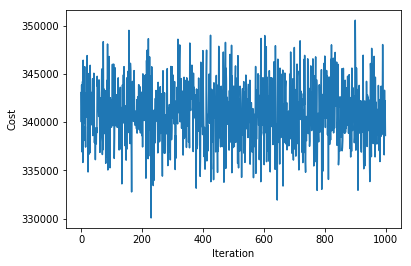

In [22]:
plt.plot(total_rewards)
plt.xlabel('Iteration')
plt.ylabel('Cost')   

plt.show()

In [ ]:
plt.plot(total_rewards)
plt.xlabel('Iteration')
plt.ylabel('Cost')   

plt.show()

## Step 9: Watch the Agent play

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./models/model.ckpt
Score:  -11240.255250089987


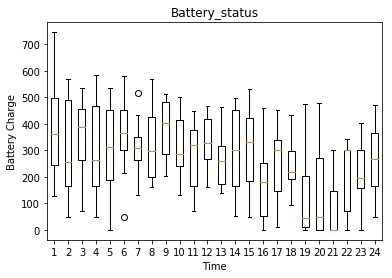

In [20]:
test_days = 10
with tf.Session() as test_sess:

    test_game = env()

    # Load the model
    saver.restore(test_sess, "./models/model.ckpt")

    test_state = test_game.reset()
    test_days = 10


    test_rewards = []
    test_battery=[]

    for i in range(24*test_days):
        ## EPSILON GREEDY STRATEGY
        # Choose action a from state s using epsilon greedy.
        ## First we randomize a number
        test_exp_exp_tradeoff = np.random.rand()

        test_explore_probability = 0.01
        test_state = np.array([test_state])

        if (test_explore_probability > test_exp_exp_tradeoff):
            # Make a random action (exploration)
            test_action = random.choice(possible_actions)

        else:
            # Get action from Q-network (exploitation)
            # Estimate the Qs values state

            test_Qs = test_sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: test_state})

            # Take the biggest Q value (= the best action)
            test_choice = np.argmax(test_Qs)
            test_action = possible_actions[int(test_choice)]

        test_state, test_reward, test_terminal, test_done = test_game.step(test_action)
#         print(state, action)
        test_battery.append(test_state[-2])
        test_rewards.append(test_reward)

    print("Score: ", sum(test_rewards)/test_days)



test_battery_status = [[] for i in range(24)]
test_time = -1

for test_i in range(0, 24*test_days):
    test_time +=1
    test_battery_status[test_time%24].append(test_battery[test_i])


fig1, ax1 = plt.subplots()
ax1.set_title('Battery_status')
ax1.boxplot(test_battery_status)
plt.xlabel('Time')
plt.ylabel('Battery Charge')
plt.show()   

In [ ]:
act = [[0,0,1],[0,1,0],[1,0,0]]

duration = 24 * 30
a = env()
r_grid = [0 for x in range(24)]
for i in range(duration):
    obs, reward, done, info = a.step(act[0])
    r_grid[i%24] += reward  

a = env()
r_random = [0 for x in range(24)]
for i in range(duration):
    action = random.randint(1, 3)
    if(action==1):
        obs, reward, done, info = a.step(act[0])
        r_random[i%24] += reward  

    elif(action==2):  
        obs, reward, done, info = a.step(act[1])
        r_random[i%24] += reward 
        
    if(action==3):  
        obs, reward, done, info = a.step(act[2])
        r_random[i%24] += reward     
    
#     if(i%24==0):
#         a.render()


a = env()
r_rule = [0 for x in range(24)]
for i in range(duration):
    time = i%24
    action = 1
    
    if(time<9):
        action = 3
    else:
        action = 2
        
    if(action==1):
        obs, reward, done, info = a.step(act[0])
        r_rule[i%24] += reward  

    elif(action==2):  
        obs, reward, done, info = a.step(act[1])
        r_rule[i%24] += reward 
        
    if(action==3):  
        obs, reward, done, info = a.step(act[2])
        r_rule[i%24] += reward    
        


plot_grid = [abs(x/10) for x  in r_grid]
plot_random = [abs(x/10) for x in r_random]
plot_rule = [abs(x/10) for x in r_rule]

x = [a for a in range(24)]
y = [plot_grid, plot_random, plot_rule]
labels = ['Grid', 'Random : Grid with Battery', 'RuleBased : Grid with Battery']


for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)
    
plt.xlabel('time (hours)')
plt.ylabel('Cost (x)')

plt.legend()
plt.show()



print('Total Reward Grid Only', sum(r_grid))
print('Total Reward Grid with Random Battery',sum(r_random))
print('Total Reward Rule Based',sum(r_rule))